In [1]:
import xupy as xp
import matplotlib.pyplot as plt
# from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.woofer_tweeter_ao_class import WooferTweeterAO
from ekarus.e2e.utils.image_utils import reshape_on_mask
from numpy.ma import masked_array


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
wt = WooferTweeterAO('test_wfs')#'ristretto')
KL,_ = wt.define_KL_modes(wt.dm,zern_modes=2)

Modulating 0 [lambda/D] with 0 modulation steps
Starting modal basis generation...
Input shapes: pupil_mask=(120, 120), influence_functions=(1261, 11304)
Step 1: Removing modes from influence functions...
Generated Zernike modes shape: (2, 120, 120)
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 4.620157241821289
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...
Step 5: Calculating modal basis...
Step 6: Adding Zernike modes to basis...
Final shapes: kl_basis=(1260, 11304), m2c=(1261, 1260)


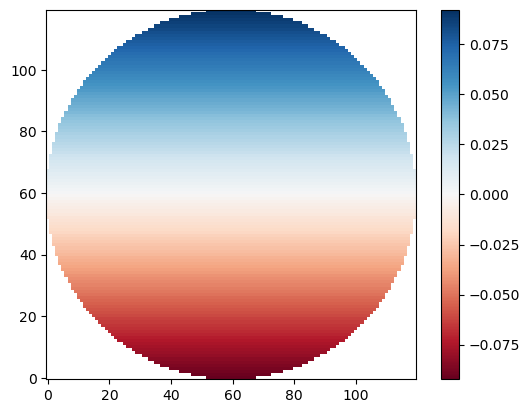

In [3]:
mode_id = 1
mode = KL[mode_id,:]
amp = 1e-8

m2rad = 2*xp.pi/wt.wfs1.lambdaInM
lambdaOverD = wt.wfs1.lambdaInM/wt.pupilSizeInM
nPhotons = None

ef_amp = 1-wt.cmask
in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)


plt.figure()
plt.imshow(masked_array(xp.asnumpy(xp.angle(in_ef)),xp.asnumpy(wt.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()

Total flux on detector is: 11304 counts
Total flux on zWFS detector is: 11304 counts


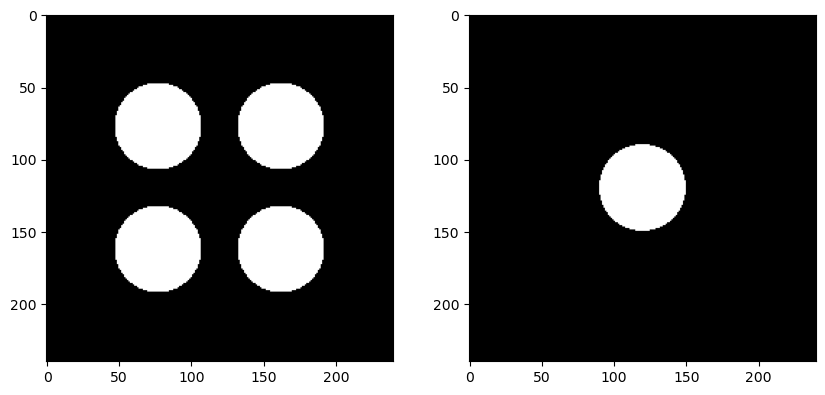

In [4]:
def get_slope(sc,in_ef, lambdaOverD, nPhotons=None):
    intensity = sc._wfs.get_intensity(in_ef, lambdaOverD)
    detector_image = sc._detector.image_on_detector(intensity, photon_flux=nPhotons)
    A = detector_image[~sc._roi_masks[0]]
    B = detector_image[~sc._roi_masks[1]]
    C = detector_image[~sc._roi_masks[2]]
    D = detector_image[~sc._roi_masks[3]]
    up_down = (A+B) - (C+D)
    left_right = (A+C) - (B+D)
    # print(xp.sum(abs(up_down)),xp.sum(abs(left_right)))
    slopes = xp.hstack((up_down, left_right))
    return slopes

def get_delta_slope(in_ef, lambdaOverD, nPhotons=None):
    push_slopes = get_slope(wt.sc1,in_ef,lambdaOverD=lambdaOverD,nPhotons=nPhotons)
    push_frame = wt.ccd1.last_frame.copy()
    pull_slopes = get_slope(wt.sc1,xp.conj(in_ef),lambdaOverD=lambdaOverD,nPhotons=nPhotons)
    pull_frame = wt.ccd1.last_frame.copy()
    slopes = (push_slopes-pull_slopes)/amp/2
    dframe = (push_frame-pull_frame)/2
    return slopes,dframe


slope_null,_ = get_delta_slope(ef_amp.astype(xp.cfloat),lambdaOverD)
unmod_img = wt.ccd1.last_frame.copy()
flux = xp.sum(unmod_img)
print(f'Total flux on detector is: {flux:1.0f} counts')
pyr_masks = xp.sum(1-wt.sc1._roi_masks,axis=0)

zslope_null = wt.sc2.compute_slopes(ef_amp.astype(xp.cfloat),lambdaOverD,nPhotons=None)
zimage_null = wt.ccd2.last_frame.copy()
zern_mask = 1-wt.sc2._roi_masks
zflux = xp.sum(zimage_null)
print(f'Total flux on zWFS detector is: {zflux:1.0f} counts')


plt.figure(figsize=(10,4.5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(pyr_masks),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(zern_mask),cmap='gray')

Modulating 0 [lambda/D] with 0 modulation steps


Text(0.5, 1.0, 'Photons inside mask: 45%')

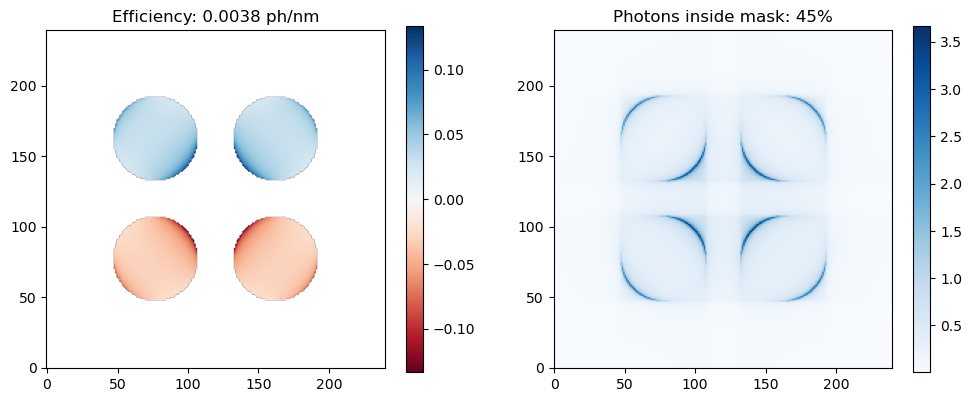

In [5]:
wt.wfs1.set_modulation_angle(0.0)
# Unmodulated case
slopes,dframe = get_delta_slope(in_ef,lambdaOverD)
unmod_img = wt.ccd1.last_frame.copy()

efficiency = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux
nPhotOut = xp.sum(unmod_img[pyr_masks.astype(bool)])
thrp = nPhotOut/flux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dframe),mask=xp.asnumpy(1-pyr_masks)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(unmod_img),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

Modulating 3 [lambda/D] with 20 modulation steps


Text(0.5, 1.0, 'Photons inside mask: 88%')

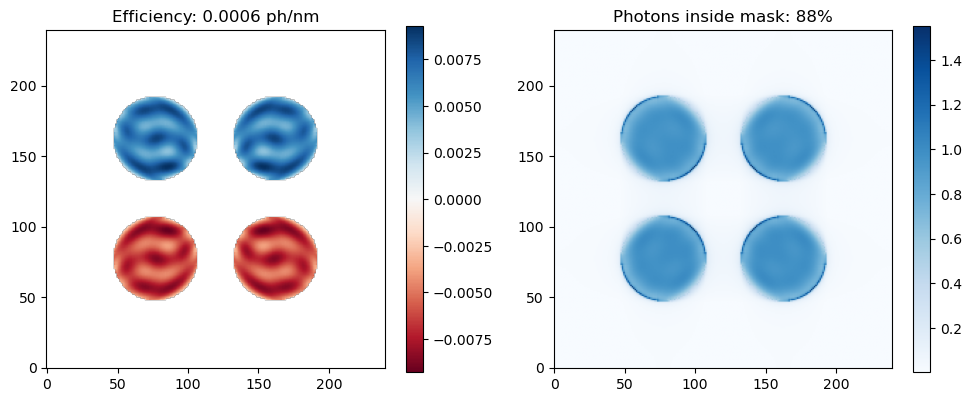

In [6]:
wt.wfs1.set_modulation_angle(3.0)
# Modulated case
slopes,dframe = get_delta_slope(in_ef,lambdaOverD)
unmod_img = wt.ccd1.last_frame.copy()

efficiency = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux
nPhotOut = xp.sum(unmod_img[pyr_masks.astype(bool)])
thrp = nPhotOut/flux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dframe),mask=xp.asnumpy(1-pyr_masks)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(unmod_img),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

Text(0.5, 1.0, 'Photons inside mask: 76%')

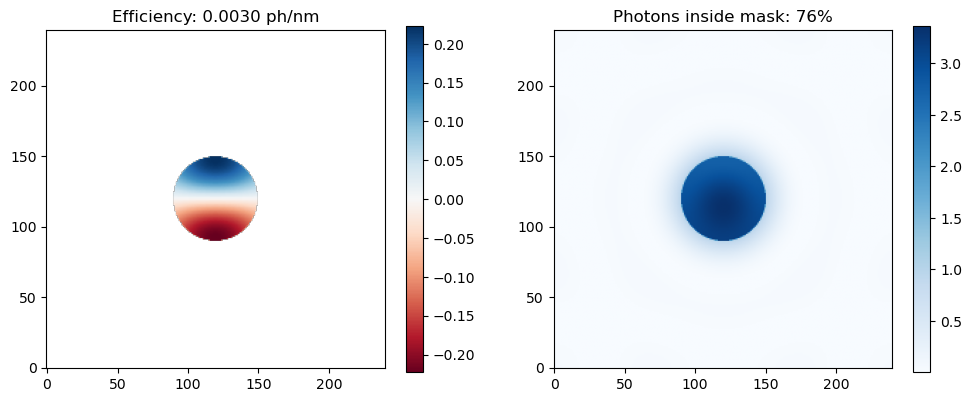

In [7]:
push_signal = wt.sc2.compute_slopes(in_ef,lambdaOverD,nPhotons=None)
push_zimage = wt.ccd2.last_frame.copy()
pull_signal = wt.sc2.compute_slopes(xp.conj(in_ef),lambdaOverD,nPhotons=None)
pull_zimage = wt.ccd2.last_frame.copy()

zslope = (push_signal-pull_signal)/2
dzimage = (push_zimage-pull_zimage)/2

efficiency = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux
nPhotOut = xp.sum(pull_zimage[zern_mask.astype(bool)])
thrp = nPhotOut/zflux

plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.imshow(masked_array(xp.asnumpy(dzimage),mask=xp.asnumpy(1-zern_mask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Efficiency: {efficiency/(amp*1e+9):1.4f} ph/nm')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(pull_zimage),origin='lower',cmap='Blues')
plt.colorbar()
plt.title(f'Photons inside mask: {thrp*1e+2:1.0f}%')

In [8]:
# Efficiency vs amplitude, modes 5,50,500

In [ ]:
# Efficiency vs mode, small amplitude
Nmax = 1000

zsens = xp.zeros(Nmax)
pyrsens = xp.zeros(Nmax)
upyrsens = xp.zeros(Nmax)

rMod = 3.0

amp = 1e-8

for mode_id in range(Nmax):
    mode = KL[mode_id,:]
    in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,wt.cmask),dtype=xp.cfloat)

    # Unmodulated case
    wt.wfs1.set_modulation_angle(0.0,verbose=False)
    _,dframe = get_delta_slope(in_ef,lambdaOverD)
    upyrsens[mode_id] = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux

    # Modulated case
    wt.wfs1.set_modulation_angle(rMod,verbose=False)
    _,dframe = get_delta_slope(in_ef,lambdaOverD)
    pyrsens[mode_id] = xp.sum(xp.abs(dframe[pyr_masks.astype(bool)]))/flux

    # zWFS case
    wt.sc2.compute_slopes(in_ef,lambdaOverD,nPhotons=None)
    push_zimage = wt.ccd2.last_frame.copy()
    wt.sc2.compute_slopes(xp.conj(in_ef),lambdaOverD,nPhotons=None)
    pull_zimage = wt.ccd2.last_frame.copy()
    dzimage = (push_zimage-pull_zimage)/2
    zsens[mode_id] = xp.sum(xp.abs(dzimage[zern_mask.astype(bool)]))/zflux




Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Modulating 0 [lambda/D] with 0

In [ ]:
x = xp.asnumpy(xp.arange(Nmax)+1)

plt.figure()
plt.plot(x,xp.asnumpy(upyrsens/(amp*1e+9)),'-o',label='Unmod pyWFS')
plt.plot(x,xp.asnumpy(pyrsens/(amp*1e+9)),'-o',label=f'{rMod:1.0f} '+r'$\lambda/D$ pyWFS')
plt.plot(x,xp.asnumpy(zsens/(amp*1e+9)),'-o',label='zWFS')
plt.grid()
plt.legend()
plt.xscale('log')
plt.xlabel('KL mode')
plt.ylabel('Sensitivity [ph/nm]')